# The Solow Model

By Mathilde Maix & Nina Frandsen Jensen

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
from sympy import symbols, lambdify
from matplotlib import pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

import modelproject
from modelproject import SolowModelClass
model = SolowModelClass()

# Model description

**Solow model** 

Production function:
$$
Y_t = K_t^αH_t^σ(A_tL_t)^{(1-α-σ)}
$$

Y is output, K is physical capital, L is labor, H is human capital and A is technology. α and σ are the output elasticities of physical capital and human capital, respectively, and (1-α-σ) is the output elasticity of labor. 
Savings are divided in physical capital savings and human capital savings. They are defined as a constant fraction of the income. 
$$
S_t=(s_K+s_H)Y_t
$$

The accumulation of physical capital over time is defined as:
$$
K_{t+1} = s_KY_t + (1-δ)K_t
$$
where δ is the depreciation rate of capital, and $K_{t+1}$ and $K_t$ are the levels of physical capital in periods t+1 and t, respectively.

The accumulation of human capital over time is defined as:
$$
H_{t+1} = s_HY_t +(1-δ)H_t
$$
where δ is the depreciation rate of capital and $H_{t+1}$ and $H_t$ are the levels of human capital in periods t+1 and t, respectively.

Finally, the level of technology and labor are defined as:
$$
A_{t+1} = (1+g)A_t
$$
$$
L_{t+1} = (1+n)L_t
$$
where g is the rate of technological progress and n is the population growth. 

We define tilde-variables:
$$
\tilde{y}_{t}= \frac{Y_t}{A_tL_t}
$$
$$
\tilde{k}_{t}= \frac{K_t}{A_tL_t}
$$
$$
\tilde{h}_{t}= \frac{H_t}{A_tL_t}
$$
We define the transitions equation for physical capital and human capital as

$$
\begin{aligned}

    \tilde{k}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_K \tilde{k}_t^{\alpha} \tilde{h}_t^{σ} + (1-\delta) \tilde{k}_t),\\
    
    \tilde{h}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_H \tilde{h}_t^{\alpha} \tilde{h}_t^{σ} + (1-\delta) \tilde{h}_t).\\

\end{aligned}
$$


## Analytical solution

We begin by trying to solve the general Solow model analytically by using simpy solve.

In [2]:
# Define the variables and parameters
k, L, s, delta, alpha, n, g = sm.symbols('k L s delta alpha n g')

# Define the production function
Y = k**alpha * L**(1-alpha)

# Define the savings and accumulation equations
S = s*Y
K_next = S + (1-delta)*k

# Define the labor accumulation equation
L_next = (1+n)*L

# Define the system of equations and solve for the steady state values
system = [Y - delta*k - K_next,
          S - K_next,
          L_next - L]

ss_sol = sm.solve(system, [k, L])

# Define the steady state function
k_ss = sm.lambdify((s, delta, alpha, n, g), ss_sol[0])

# Test the function with example parameters
params = (0.6, 0.05, 0.3, 0.01, 0.025)
print(k_ss(*params))

(0, 0)


Simpy solve on the general Solow model was unsuccessful. This is because in the Solow model, the steady state values of k, L, and A are normally found by solving a system of nonlinear equations numerically, rather than analytically.

So instead, we define the model in our py-file, and use the transition equations to solve the Solow model analytically.

In [3]:
k_tilde_ss_A = model.solve_analytical_ss()

                                1  
                              ─────
                              α - 1
⎛       -φ ⎛           2    ⎞⎞     
⎜h_tilde  ⋅⎝δ + (g + 1)  - 1⎠⎟     
⎜────────────────────────────⎟     
⎝             sₖ             ⎠     
                                1  
                              ─────
                              φ - 1
⎛       -α ⎛           2    ⎞⎞     
⎜k_tilde  ⋅⎝δ + (g + 1)  - 1⎠⎟     
⎜────────────────────────────⎟     
⎝             sₕ             ⎠     


## Numerical solution

Now we solve the model numerically. We have defined the steady states in a model in our py file. We begin by finding an estimation for $\tilde k_t$ and $\tilde h_t$.

In [4]:
ss_k_h = model.solve_steady_state()

Steady state found:
k_tilde = 0.2273539320183882
h_tilde = 0.22735393201838805


We can illustrate the convergence in 2 graphs.

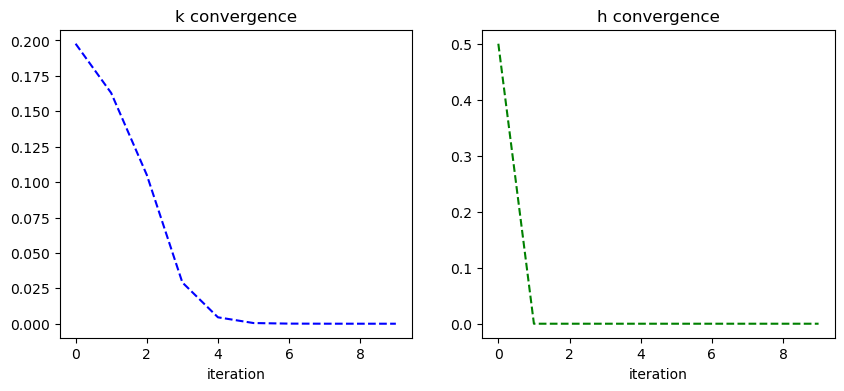

In [5]:
convergence_ss = model.convergence()

Now that we have estimated the capital and human capital steady states, we can also estimate the production

In [6]:
y_ss = model.y_steady_state()

Y steady state found= 0.5954507743338711


Then we wish to illustrate the steady states in a phase diagram. 

In [7]:
# Define the variables and parameters
k_tilde, h_tilde = sm.symbols('ktilde_t, htilde_t')
sK, sH, g, n, delta, alpha, sigma = sm.symbols('s_K, s_H, g, n, delta, alpha, sigma')

# Define the transition equations
k_trans = sm.Eq(k_tilde, 
                1/((1+n)*(1+g))*(sK*k_tilde**alpha*h_tilde**sigma+(1-delta)*k_tilde))
h_trans = sm.Eq(h_tilde, 
                1/((1+n)*(1+g))*(sH*k_tilde**alpha*h_tilde**sigma+(1-delta)*h_tilde))

# Derive nullclines from transition equations 
nullcline_k = sm.solve(k_trans,h_tilde)[0] 
null_k = sm.Eq(h_tilde, nullcline_k)

nullcline_h = sm.solve(h_trans,h_tilde)[0]
null_h = sm.Eq(h_tilde, nullcline_h)

# Use lambdify
null_k_func = sm.lambdify([k_tilde, alpha, delta, g, n, sigma, sK], nullcline_k)
null_h_func = sm.lambdify([k_tilde, alpha, delta, g, n, sigma, sH], nullcline_h)
 
# Define values 
k_tilde_vec = np.linspace(1,5000,100)  

alpha = 0.3
delta = 0.02
g = 0.02
n = 0.01
sigma = 0.5
sH = 0.2
sK = 0.3

null_k_val = null_k_func(k_tilde_vec,alpha,delta,g, n, sigma, sK)
null_h_val = null_h_func(k_tilde_vec,alpha,delta,g, n, sigma, sH)

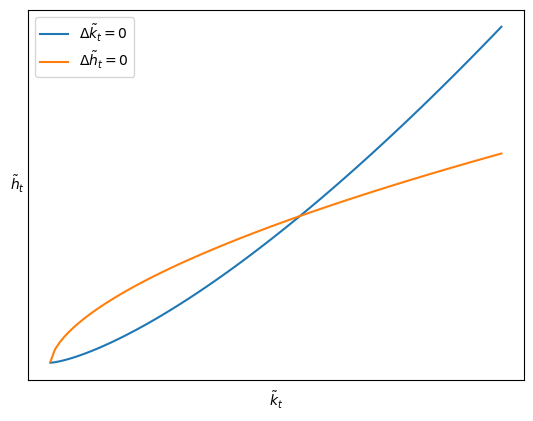

In [8]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(k_tilde_vec, null_k_val, label = r'$ \Delta \tilde{k}_t = 0$')
ax.plot(k_tilde_vec, null_h_val, label = r'$ \Delta \tilde{h}_t = 0$');
ax.set_xlabel(r'$\tilde{k}_t$',)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel(r'$\tilde{h}_t$', rotation = 0)

ax.legend(loc='upper left');

From the power of $\tilde{k}$, we observe that the nullcline for $\triangle\tilde{k} = 0$ is convex, while the nullcline for $\triangle\tilde{h} = 0$ is concave in the $\tilde{k}$ dimension. We know wish to show the nullclines in a fase diagram

The fase diagram shows the transition to steady state. The steady state is where the null clines intersect each other. 
Now we will find the steady state and graph the convergence. 

# Extension of the model


In this experiment, we will investigate the impact of a permanent increase in the investment rate in human capital.

In [9]:
from matplotlib.lines import Line2D
from ipywidgets import interact, FloatSlider

def plot_combinations_new(sk, sh, alpha, phi, n, g, delta):
    # SS equations
    ktilde_ss = ((sk ** (1 - phi) * sh ** phi) / (n + g + delta + n * g)) ** (1 / (1 - alpha - phi))
    htilde_ss = ((sk ** alpha * sh ** (1 - alpha)) / (n + g + delta + n * g)) ** (1 / (1 - alpha - phi))
    ktildenew_ss = ((sk ** (1 - phi) * (sh * 1.3) ** phi) / (n + g + delta + n * g)) ** (1 / (1 - alpha - phi))
    htildenew_ss = ((sk ** alpha * (sh * 1.3) ** (1 - alpha)) / (n + g + delta + n * g)) ** (1 / (1 - alpha - phi))
    
    # Grids
    ktilde_values = np.linspace(0.01, 2 * ktilde_ss, 100)
    htilde_values = np.linspace(0.01, 2 * htilde_ss, 100)
    Ktilde, Htilde = np.meshgrid(ktilde_values, htilde_values)
    
    # Nullclines
    delta_ktilde = (1 / ((1 + n) * (1 + g))) * (sk * Ktilde ** alpha * Htilde ** phi - (n + g + delta + n * g) * Ktilde)
    delta_htilde = (1 / ((1 + n) * (1 + g))) * (sh * Ktilde ** alpha * Htilde ** phi - (n + g + delta + n * g) * Htilde)
    delta_htildenew = (1 / ((1 + n) * (1 + g))) * (sh * 1.3 * Ktilde ** alpha * Htilde ** phi - (n + g + delta + n * g) * Htilde)

    # Formatting
    plt.figure(figsize=(8, 8))
    plt.contour(Ktilde, Htilde, delta_ktilde, levels=[0], colors=['pink'])
    plt.contour(Ktilde, Htilde, delta_htilde, levels=[0], colors=['purple']) 
    plt.contour(Ktilde, Htilde, delta_htildenew, levels=[0], colors=['orange']) 
    plt.plot([],[],[])
    
    #SS 1st equilibrium
    plt.scatter(ktilde_ss, htilde_ss, color='red', marker='o', zorder=3)
    plt.annotate("EQ1", (ktilde_ss, htilde_ss), textcoords="offset points", xytext=(-10, 5), fontsize=12, color='red', zorder=3)
    
    #SS New equilibrium
    plt.scatter(ktildenew_ss, htildenew_ss, color='red', marker='o', zorder=3)
    plt.annotate("EQ2", (ktildenew_ss, htildenew_ss), textcoords="offset points", xytext=(-10, 5), fontsize=12, color='red', zorder=3)

    plt.xlabel('$\~{k}_t$')
    plt.ylabel('$\~{h}_t$')
    plt.title('Interactive phase diagram')

    # Legend
    custom_lines = [Line2D([0], [0], color="pink", lw=4),
                    Line2D([0], [0], color="purple", lw=4),
                    Line2D([0], [0], color="orange", lw=4),
                    Line2D([0], [0], marker='o', color="red", markersize=10),
                    Line2D([0], [0], marker='o', color="red", markersize=10)]

        
    plt.legend(custom_lines, ['$\Delta k_t=0$', '$\Delta h_t=0$','$\Delta h^{new}_t=0$', 'Equilibrium 1', 'Equilibrium 2'])

    # Axis
    plt.xlim(0, 50)
    plt.ylim(0, 50)

    plt.grid()
    plt.show()

# Sliders
sk_slider = FloatSlider(min=0.1, max=0.9, step=0.01, value=0.3, description=r's_K')
sh_slider = FloatSlider(min=0.1, max=0.9, step=0.01, value=0.3, description=r's_H')
alpha_slider = FloatSlider(min=0, max=0.5, step=0.01, value=0.3, description=r'alpha')
phi_slider = FloatSlider(min=0, max=0.5, step=0.01, value=0.3, description=r'varphi')
n_slider = FloatSlider(min=0, max=0.1, step=0.001, value=0.01, description=r'n')
g_slider = FloatSlider(min=0, max=0.1, step=0.001, value=0.02, description=r'g')
delta_slider = FloatSlider(min=0, max=0.1, step=0.001, value=0.05, description=r'$\delta$')

# Interactive plot
interact(plot_combinations_new, sk=sk_slider, sh=sh_slider, alpha=alpha_slider, phi=phi_slider, n=n_slider, g=g_slider, delta=delta_slider);

interactive(children=(FloatSlider(value=0.3, description='s_K', max=0.9, min=0.1, step=0.01), FloatSlider(valu…

When we have an increase in $s_H$, indicating a higher investment in human capital per worker, several effects can be observed. Initially, there will be an increase in income due to the improved productivity resulting from the increased human capital. Additionally, there will be an increase in physical capital as a result of the investment made during the first period.

However, the effects of increased human capital and physical capital will not stop after the first period, they  will continue to accumulate over time. The investment in human capital leads to a higher level of skills and knowledge among workers, which enhances their productivity and, therefore, their income. The higher income allows for further savings and investment in physical capital, leading to even more productive capacity in next periods.

# Conclusion

This project focused on studying the effects of increasing investment in human capital using the Solow growth model. By analyzing the model, we found that increasing the investment rate in human capital, represented by $s_H$, had significant positive impacts. In the initial period, it led to higher productivity, income, and physical capital accumulation. These benefits continued to grow over time, resulting in sustained economic growth.

We visualized the model's dynamics by plotting null-clines. These visualizations helped us understand the relationship between investment rates, steady states, and convergence paths.

Overall, this project highlighted the importance of investing in human capital for economic growth and development. The Solow growth model, by considering human capital alongside physical capital and technological progress, provided valuable insights into the dynamics of economic growth and the potential benefits of investments in human capital.